In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/Deep Leraning & Computer Vision/CV_lab10/cats.zip' -d '/content/dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/cats/train/5499.jpg  
  inflating: /content/dataset/cats/train/55.jpg  
  inflating: /content/dataset/cats/train/550.jpg  
  inflating: /content/dataset/cats/train/5500.jpg  
  inflating: /content/dataset/cats/train/5501.jpg  
  inflating: /content/dataset/cats/train/5502.jpg  
  inflating: /content/dataset/cats/train/5503.jpg  
  inflating: /content/dataset/cats/train/5504.jpg  
  inflating: /content/dataset/cats/train/5505.jpg  
  inflating: /content/dataset/cats/train/5506.jpg  
  inflating: /content/dataset/cats/train/5507.jpg  
  inflating: /content/dataset/cats/train/5508.jpg  
  inflating: /content/dataset/cats/train/5509.jpg  
  inflating: /content/dataset/cats/train/551.jpg  
  inflating: /content/dataset/cats/train/5510.jpg  
  inflating: /content/dataset/cats/train/5511.jpg  
  inflating: /content/dataset/cats/train/5512.jpg  
  inflating: /content/dataset/cats/train/5513.jpg  
  inflating: /con

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn.functional as F
from tqdm import tqdm


# Implementation of VQVAE
github: https://github.com/MishaLaskin/vqvae/tree/master

github2: https://github.com/zalandoresearch/pytorch-vq-vae/blob/master/vq-vae.ipynb

## 1. Encoder + VectorQuantizer + Decoder

In [4]:
class ResidualLayer(nn.Module):
  def __init__(self, in_dim, hidden_dim, res_hidden_dim):
    super().__init__()

    self.res_block = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(in_dim, res_hidden_dim, kernel_size=3, stride=1, padding=1, bias=False),

        nn.ReLU(),
        nn.Conv2d(res_hidden_dim, hidden_dim, kernel_size=1, stride=1, bias=False)
    )

  def forward(self, x):
    x = x + self.res_block(x)
    return x

In [5]:
class ResidualStack(nn.Module):
  def __init__(self, in_dim, hidden_dim, res_hidden_dim, n_res_layers):
    super().__init__()

    self.n_res_layers = n_res_layers
    self.stack = nn.ModuleList(
        [ResidualLayer(in_dim, hidden_dim, res_hidden_dim)] * n_res_layers
    )
    self.act = nn.ReLU()

  def forward(self, x):
    for layer in self.stack:
      x = layer(x)
    x = self.act(x)
    return x

In [6]:
class Encoder(nn.Module):
  def __init__(self, in_channels, hidden_dim, res_hidden_dim, n_res_layers):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels, hidden_dim // 2, kernel_size=4,
                           stride=2, padding=1)
    self.conv2 = nn.Conv2d(hidden_dim // 2, hidden_dim, kernel_size=4,
                           stride=2, padding=1)
    self.conv3 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3,
                           stride=1, padding=1)

    self.residual_stack = ResidualStack(hidden_dim, hidden_dim, res_hidden_dim,
                                        n_res_layers)
    self.act = nn.ReLU()

  def forward(self, x):
    x = self.conv1(x)
    x = self.act(x)

    x = self.conv2(x)
    x = self.act(x)

    x = self.conv3(x)
    return self.residual_stack(x)

In [7]:
class VectorQuantizer(nn.Module):
  def __init__(self, num_embeddings, embedding_dim, commitment_cost):
    super().__init__()

    self.embedding_dim = embedding_dim
    self.num_embeddings = num_embeddings
    self.commitment_cost = commitment_cost

    self.embedding = nn.Embedding(self.num_embeddings, self.embedding_dim)
    self.embedding.weight.data.uniform_(-1.0 / self.num_embeddings,
                                        1.0 / self.num_embeddings)

  def forward(self, x):
    x = x.permute(0, 2, 3, 1).contiguous()
    x_shape = x.shape

    flat_x = x.view(-1, self.embedding_dim)

    distances = (torch.sum(flat_x**2, dim=1, keepdim=True)
                + torch.sum(self.embedding.weight**2, dim=1)
                - 2 * torch.matmul(flat_x, self.embedding.weight.T))

    #Encoding
    encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    encodings = torch.zeros(encoding_indices.shape[0], self.num_embeddings,
                            device=x.device)
    encodings.scatter_(1, encoding_indices, 1)

    #quantize and unflatten
    quantized = torch.matmul(encodings, self.embedding.weight).view(x_shape)

    #Loss
    e_latent_loss = F.mse_loss(quantized.detach(), x)
    q_latent_loss = F.mse_loss(quantized, x.detach())
    loss = q_latent_loss + self.commitment_cost * e_latent_loss

    quantized = x + (quantized - x).detach()
    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

    return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings, encoding_indices


In [8]:
class Decoder(nn.Module):
  def __init__(self, in_channels, hidden_dim, res_hidden_dim, n_res_layers):
    super().__init__()

    self.conv_transpose1 = nn.ConvTranspose2d(in_channels, hidden_dim, kernel_size=3,
                           stride=1, padding=1)
    self.residual_stack = ResidualStack(hidden_dim, hidden_dim, res_hidden_dim,
                                        n_res_layers)
    self.conv_transpose2 = nn.ConvTranspose2d(hidden_dim, hidden_dim//2,
                                              kernel_size=4, stride=2, padding=1)
    self.conv_transpose3 = nn.ConvTranspose2d(hidden_dim//2, 3,
                                              kernel_size=4, stride=2, padding=1)
    self.act = nn.ReLU()

  def forward(self, x):
    x = self.conv_transpose1(x)
    x = self.residual_stack(x)
    x = self.conv_transpose2(x)
    x = self.act(x)
    return self.conv_transpose3(x)

# 2. Model

In [9]:
class Model(nn.Module):
  def __init__(self, hidden_dim, res_hidden_dim, n_res_layers,
               num_embeddings, embedding_dim, commitment_cost):
    super().__init__()

    self.encoder = Encoder(3, hidden_dim, res_hidden_dim, n_res_layers)
    self.pre_vq_conv = nn.Conv2d(hidden_dim, embedding_dim,
                                 kernel_size=1, stride=1)
    self.vq_vae = VectorQuantizer(num_embeddings, embedding_dim, commitment_cost)
    self.decoder = Decoder(embedding_dim, hidden_dim, res_hidden_dim, n_res_layers)

  def forward(self, x):
    z = self.encoder(x)
    z = self.pre_vq_conv(z)

    loss, quantized, perplexity, _, _ = self.vq_vae(z)
    x_reconstructed = self.decoder(quantized)

    return loss, x_reconstructed, perplexity

#3. CatsDataset

In [10]:
class CatsDataset(Dataset):
  def __init__(self, folder_path, transform=None):
    super().__init__()

    self.folder_path = folder_path
    self.image_files = sorted(os.listdir(self.folder_path))
    self.transform = transform

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, index):
    image_file = self.image_files[index]
    image = Image.open(os.path.join(self.folder_path, image_file))
    image = np.array(image).astype(np.float32)

    if self.transform:
      augmented = self.transform(image=image)
      image = augmented['image']
    return image

In [11]:
transform = A.Compose([
    A.Normalize(mean=0.5, std=1.0, max_pixel_value=255.0),
    ToTensorV2()
])
df_train = CatsDataset('/content/dataset/cats/train', transform)
df_test = CatsDataset('/content/dataset/cats/test', transform)

train_loader = DataLoader(df_train, batch_size=16, shuffle=True, num_workers=2)
test_loader = DataLoader(df_test, batch_size=16, shuffle=False, num_workers=2)

In [12]:
num_training_updates = 15000

hidden_dim = 256
res_hidden_dim = 32
n_res_layers = 2

embedding_dim = 64
num_embeddings = 512
commitment_cost = 0.05
learning_rate = 2e-4

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(hidden_dim, res_hidden_dim, n_res_layers,
              num_embeddings, embedding_dim, commitment_cost).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in tqdm(range(num_training_updates)):
    data = next(iter(train_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data)
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

  0%|          | 0/15000 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  1%|          | 100/15000 [00:19<1:06:37,  3.73it/s]

100 iterations
recon_error: 0.047
perplexity: 2.009



  1%|▏         | 200/15000 [00:39<56:36,  4.36it/s]

200 iterations
recon_error: 0.027
perplexity: 2.366



  2%|▏         | 300/15000 [00:56<38:35,  6.35it/s]

300 iterations
recon_error: 0.019
perplexity: 3.006



  3%|▎         | 400/15000 [01:13<38:27,  6.33it/s]

400 iterations
recon_error: 0.017
perplexity: 2.970



  3%|▎         | 500/15000 [01:31<52:28,  4.61it/s]

500 iterations
recon_error: 0.017
perplexity: 3.068



  4%|▍         | 600/15000 [02:00<55:10,  4.35it/s]

600 iterations
recon_error: 0.017
perplexity: 3.408



  5%|▍         | 700/15000 [02:18<38:28,  6.19it/s]

700 iterations
recon_error: 0.017
perplexity: 4.050



  5%|▌         | 800/15000 [02:35<38:01,  6.22it/s]

800 iterations
recon_error: 0.014
perplexity: 3.863



  6%|▌         | 900/15000 [02:52<43:18,  5.43it/s]

900 iterations
recon_error: 0.014
perplexity: 3.981



  7%|▋         | 1000/15000 [03:11<38:46,  6.02it/s]

1000 iterations
recon_error: 0.013
perplexity: 4.319



  7%|▋         | 1100/15000 [03:28<38:07,  6.08it/s]

1100 iterations
recon_error: 0.013
perplexity: 4.741



  8%|▊         | 1200/15000 [03:46<36:58,  6.22it/s]

1200 iterations
recon_error: 0.012
perplexity: 5.289



  9%|▊         | 1300/15000 [04:06<1:16:05,  3.00it/s]

1300 iterations
recon_error: 0.012
perplexity: 6.118



  9%|▉         | 1400/15000 [04:28<37:52,  5.99it/s]

1400 iterations
recon_error: 0.011
perplexity: 6.746



 10%|█         | 1500/15000 [04:48<37:56,  5.93it/s]

1500 iterations
recon_error: 0.010
perplexity: 7.269



 11%|█         | 1600/15000 [05:06<37:33,  5.95it/s]

1600 iterations
recon_error: 0.010
perplexity: 7.705



 11%|█▏        | 1700/15000 [05:24<50:00,  4.43it/s]

1700 iterations
recon_error: 0.010
perplexity: 8.542



 12%|█▏        | 1800/15000 [05:43<36:09,  6.08it/s]

1800 iterations
recon_error: 0.009
perplexity: 9.357



 13%|█▎        | 1900/15000 [06:02<36:23,  6.00it/s]

1900 iterations
recon_error: 0.009
perplexity: 10.292



 13%|█▎        | 2000/15000 [06:21<55:04,  3.93it/s]

2000 iterations
recon_error: 0.009
perplexity: 10.844



 14%|█▍        | 2100/15000 [06:39<35:37,  6.04it/s]

2100 iterations
recon_error: 0.009
perplexity: 11.491



 15%|█▍        | 2200/15000 [06:57<35:29,  6.01it/s]

2200 iterations
recon_error: 0.009
perplexity: 12.488



 15%|█▌        | 2300/15000 [07:17<35:53,  5.90it/s]

2300 iterations
recon_error: 0.009
perplexity: 13.124



 16%|█▌        | 2400/15000 [07:36<35:25,  5.93it/s]

2400 iterations
recon_error: 0.009
perplexity: 13.764



 17%|█▋        | 2500/15000 [07:55<51:52,  4.02it/s]

2500 iterations
recon_error: 0.008
perplexity: 14.250



 17%|█▋        | 2600/15000 [08:14<35:22,  5.84it/s]

2600 iterations
recon_error: 0.008
perplexity: 14.834



 18%|█▊        | 2700/15000 [08:32<35:03,  5.85it/s]

2700 iterations
recon_error: 0.008
perplexity: 15.463



 18%|█▊        | 2701/15000 [08:33<35:41,  5.74it/s]Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/util.py", line 133, in _remove_temp_dir
    rmtree(tempdir)
  File "/usr/lib/python3.10/shutil.py", line 731, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.10/shutil.py", line 729, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-dwzehgx_'
 19%|█▊        | 2800/15000 [08:52<36:12,  5.61it/s]

2800 iterations
recon_error: 0.008
perplexity: 15.742



 19%|█▉        | 2900/15000 [09:11<34:21,  5.87it/s]

2900 iterations
recon_error: 0.008
perplexity: 16.618



 20%|██        | 3000/15000 [09:32<52:21,  3.82it/s]

3000 iterations
recon_error: 0.008
perplexity: 17.536



 21%|██        | 3100/15000 [09:51<36:12,  5.48it/s]

3100 iterations
recon_error: 0.007
perplexity: 17.953



 21%|██▏       | 3200/15000 [10:10<34:46,  5.66it/s]

3200 iterations
recon_error: 0.007
perplexity: 18.465



 22%|██▏       | 3300/15000 [10:30<33:57,  5.74it/s]

3300 iterations
recon_error: 0.007
perplexity: 18.730



 23%|██▎       | 3400/15000 [10:49<34:56,  5.53it/s]

3400 iterations
recon_error: 0.007
perplexity: 19.381



 23%|██▎       | 3500/15000 [11:09<44:30,  4.31it/s]

3500 iterations
recon_error: 0.007
perplexity: 19.774



 24%|██▍       | 3600/15000 [11:28<34:01,  5.59it/s]

3600 iterations
recon_error: 0.007
perplexity: 20.041



 25%|██▍       | 3700/15000 [11:48<52:37,  3.58it/s]

3700 iterations
recon_error: 0.007
perplexity: 20.491



 25%|██▌       | 3800/15000 [12:08<33:27,  5.58it/s]

3800 iterations
recon_error: 0.007
perplexity: 21.063



 26%|██▌       | 3900/15000 [12:28<48:25,  3.82it/s]

3900 iterations
recon_error: 0.007
perplexity: 21.518



 27%|██▋       | 4000/15000 [12:48<32:52,  5.58it/s]

4000 iterations
recon_error: 0.007
perplexity: 22.067



 27%|██▋       | 4100/15000 [13:08<41:08,  4.42it/s]

4100 iterations
recon_error: 0.007
perplexity: 22.394



 28%|██▊       | 4200/15000 [13:29<32:42,  5.50it/s]

4200 iterations
recon_error: 0.007
perplexity: 22.612



 29%|██▊       | 4300/15000 [13:49<50:51,  3.51it/s]

4300 iterations
recon_error: 0.007
perplexity: 23.104



 29%|██▉       | 4400/15000 [14:11<32:51,  5.38it/s]

4400 iterations
recon_error: 0.006
perplexity: 23.424



 30%|███       | 4500/15000 [14:31<32:44,  5.35it/s]

4500 iterations
recon_error: 0.006
perplexity: 23.844



 31%|███       | 4600/15000 [14:53<33:11,  5.22it/s]

4600 iterations
recon_error: 0.007
perplexity: 24.213



 31%|███▏      | 4700/15000 [15:14<47:18,  3.63it/s]

4700 iterations
recon_error: 0.007
perplexity: 25.123



 32%|███▏      | 4800/15000 [15:35<32:27,  5.24it/s]

4800 iterations
recon_error: 0.006
perplexity: 25.765



 33%|███▎      | 4900/15000 [15:57<49:18,  3.41it/s]

4900 iterations
recon_error: 0.006
perplexity: 26.363



 33%|███▎      | 5000/15000 [16:18<31:33,  5.28it/s]

5000 iterations
recon_error: 0.006
perplexity: 26.640



 34%|███▍      | 5100/15000 [16:39<33:09,  4.98it/s]

5100 iterations
recon_error: 0.006
perplexity: 27.256



 35%|███▍      | 5200/15000 [17:00<32:13,  5.07it/s]

5200 iterations
recon_error: 0.006
perplexity: 27.792



 35%|███▌      | 5300/15000 [17:23<31:55,  5.07it/s]

5300 iterations
recon_error: 0.006
perplexity: 28.286



 36%|███▌      | 5400/15000 [17:46<46:42,  3.43it/s]

5400 iterations
recon_error: 0.006
perplexity: 28.066



 37%|███▋      | 5500/15000 [18:07<31:08,  5.08it/s]

5500 iterations
recon_error: 0.006
perplexity: 27.796



 37%|███▋      | 5600/15000 [18:30<33:05,  4.74it/s]

5600 iterations
recon_error: 0.006
perplexity: 28.393



 38%|███▊      | 5700/15000 [18:52<42:54,  3.61it/s]

5700 iterations
recon_error: 0.006
perplexity: 28.734



 39%|███▊      | 5800/15000 [19:14<31:24,  4.88it/s]

5800 iterations
recon_error: 0.006
perplexity: 28.518



 39%|███▉      | 5900/15000 [19:37<31:53,  4.76it/s]

5900 iterations
recon_error: 0.006
perplexity: 28.897



 40%|████      | 6000/15000 [19:59<31:55,  4.70it/s]

6000 iterations
recon_error: 0.006
perplexity: 29.490



 41%|████      | 6100/15000 [20:23<30:47,  4.82it/s]

6100 iterations
recon_error: 0.006
perplexity: 29.596



 41%|████▏     | 6200/15000 [20:46<31:43,  4.62it/s]

6200 iterations
recon_error: 0.006
perplexity: 30.061



 42%|████▏     | 6300/15000 [21:11<45:48,  3.16it/s]

6300 iterations
recon_error: 0.006
perplexity: 30.531



 43%|████▎     | 6400/15000 [21:34<29:52,  4.80it/s]

6400 iterations
recon_error: 0.006
perplexity: 31.038



 43%|████▎     | 6500/15000 [21:57<29:59,  4.72it/s]

6500 iterations
recon_error: 0.006
perplexity: 31.514



 44%|████▍     | 6600/15000 [22:33<47:48,  2.93it/s]

6600 iterations
recon_error: 0.005
perplexity: 31.901



 45%|████▍     | 6700/15000 [22:56<29:13,  4.73it/s]

6700 iterations
recon_error: 0.005
perplexity: 32.476



 45%|████▌     | 6800/15000 [23:20<30:11,  4.53it/s]

6800 iterations
recon_error: 0.005
perplexity: 33.028



 46%|████▌     | 6900/15000 [23:44<29:49,  4.53it/s]

6900 iterations
recon_error: 0.005
perplexity: 33.483



 47%|████▋     | 7000/15000 [24:08<42:59,  3.10it/s]

7000 iterations
recon_error: 0.005
perplexity: 34.209



 47%|████▋     | 7100/15000 [24:31<28:22,  4.64it/s]

7100 iterations
recon_error: 0.005
perplexity: 34.403



 48%|████▊     | 7200/15000 [24:55<27:55,  4.65it/s]

7200 iterations
recon_error: 0.005
perplexity: 35.126



 49%|████▊     | 7300/15000 [25:21<37:27,  3.43it/s]

7300 iterations
recon_error: 0.005
perplexity: 35.757



 49%|████▉     | 7400/15000 [25:46<40:42,  3.11it/s]

7400 iterations
recon_error: 0.005
perplexity: 35.797



 50%|█████     | 7500/15000 [26:10<31:12,  4.01it/s]

7500 iterations
recon_error: 0.005
perplexity: 36.627



 51%|█████     | 7600/15000 [26:34<27:56,  4.41it/s]

7600 iterations
recon_error: 0.005
perplexity: 36.974



 51%|█████▏    | 7700/15000 [27:01<36:46,  3.31it/s]

7700 iterations
recon_error: 0.005
perplexity: 37.459



 52%|█████▏    | 7800/15000 [27:26<27:13,  4.41it/s]

7800 iterations
recon_error: 0.005
perplexity: 37.528



 53%|█████▎    | 7900/15000 [27:51<26:52,  4.40it/s]

7900 iterations
recon_error: 0.005
perplexity: 37.886



 53%|█████▎    | 8000/15000 [28:17<30:09,  3.87it/s]

8000 iterations
recon_error: 0.005
perplexity: 38.149



 54%|█████▍    | 8100/15000 [28:43<40:02,  2.87it/s]

8100 iterations
recon_error: 0.005
perplexity: 38.781



 55%|█████▍    | 8200/15000 [29:08<35:13,  3.22it/s]

8200 iterations
recon_error: 0.005
perplexity: 39.307



 55%|█████▌    | 8300/15000 [29:33<26:28,  4.22it/s]

8300 iterations
recon_error: 0.005
perplexity: 39.799



 56%|█████▌    | 8400/15000 [30:01<26:15,  4.19it/s]

8400 iterations
recon_error: 0.005
perplexity: 40.543



 57%|█████▋    | 8500/15000 [30:27<25:26,  4.26it/s]

8500 iterations
recon_error: 0.005
perplexity: 40.803



 57%|█████▋    | 8600/15000 [30:53<27:00,  3.95it/s]

8600 iterations
recon_error: 0.005
perplexity: 41.228



 58%|█████▊    | 8700/15000 [31:19<25:11,  4.17it/s]

8700 iterations
recon_error: 0.005
perplexity: 41.350



 59%|█████▊    | 8800/15000 [31:47<24:35,  4.20it/s]

8800 iterations
recon_error: 0.005
perplexity: 41.885



 59%|█████▉    | 8900/15000 [32:13<24:55,  4.08it/s]

8900 iterations
recon_error: 0.005
perplexity: 42.151



 60%|██████    | 9000/15000 [32:40<24:35,  4.07it/s]

9000 iterations
recon_error: 0.005
perplexity: 42.229



 61%|██████    | 9100/15000 [33:07<24:13,  4.06it/s]

9100 iterations
recon_error: 0.005
perplexity: 43.233



 61%|██████▏   | 9200/15000 [33:34<23:47,  4.06it/s]

9200 iterations
recon_error: 0.005
perplexity: 43.620



 62%|██████▏   | 9300/15000 [34:01<23:18,  4.07it/s]

9300 iterations
recon_error: 0.005
perplexity: 44.143



 63%|██████▎   | 9400/15000 [34:29<23:54,  3.90it/s]

9400 iterations
recon_error: 0.005
perplexity: 44.554



 63%|██████▎   | 9500/15000 [34:56<22:38,  4.05it/s]

9500 iterations
recon_error: 0.005
perplexity: 45.971



 64%|██████▍   | 9600/15000 [35:24<22:28,  4.00it/s]

9600 iterations
recon_error: 0.005
perplexity: 46.935



 65%|██████▍   | 9700/15000 [35:51<22:16,  3.96it/s]

9700 iterations
recon_error: 0.005
perplexity: 46.894



 65%|██████▌   | 9800/15000 [36:20<22:11,  3.91it/s]

9800 iterations
recon_error: 0.005
perplexity: 47.898



 66%|██████▌   | 9900/15000 [36:48<21:31,  3.95it/s]

9900 iterations
recon_error: 0.005
perplexity: 49.244



 67%|██████▋   | 10000/15000 [37:16<21:14,  3.92it/s]

10000 iterations
recon_error: 0.004
perplexity: 48.944



 67%|██████▋   | 10100/15000 [37:44<20:54,  3.91it/s]

10100 iterations
recon_error: 0.004
perplexity: 49.786



 68%|██████▊   | 10200/15000 [38:12<19:58,  4.00it/s]

10200 iterations
recon_error: 0.005
perplexity: 50.591



 69%|██████▊   | 10300/15000 [38:41<22:16,  3.52it/s]

10300 iterations
recon_error: 0.005
perplexity: 50.832



 69%|██████▉   | 10400/15000 [39:12<26:16,  2.92it/s]

10400 iterations
recon_error: 0.005
perplexity: 52.040



 70%|███████   | 10500/15000 [39:40<20:34,  3.65it/s]

10500 iterations
recon_error: 0.004
perplexity: 52.362



 71%|███████   | 10600/15000 [40:10<20:15,  3.62it/s]

10600 iterations
recon_error: 0.004
perplexity: 54.064



 71%|███████▏  | 10700/15000 [40:40<19:08,  3.74it/s]

10700 iterations
recon_error: 0.004
perplexity: 53.575



 72%|███████▏  | 10800/15000 [41:09<18:32,  3.78it/s]

10800 iterations
recon_error: 0.004
perplexity: 55.327



 73%|███████▎  | 10900/15000 [41:39<18:35,  3.68it/s]

10900 iterations
recon_error: 0.004
perplexity: 55.526



 73%|███████▎  | 11000/15000 [42:09<25:47,  2.59it/s]

11000 iterations
recon_error: 0.004
perplexity: 56.828



 74%|███████▍  | 11100/15000 [42:39<18:38,  3.49it/s]

11100 iterations
recon_error: 0.004
perplexity: 57.308



 75%|███████▍  | 11200/15000 [43:09<17:52,  3.54it/s]

11200 iterations
recon_error: 0.004
perplexity: 58.446



 75%|███████▌  | 11300/15000 [43:41<17:23,  3.55it/s]

11300 iterations
recon_error: 0.004
perplexity: 59.034



 76%|███████▌  | 11400/15000 [44:12<16:39,  3.60it/s]

11400 iterations
recon_error: 0.004
perplexity: 59.587



 77%|███████▋  | 11500/15000 [44:43<19:45,  2.95it/s]

11500 iterations
recon_error: 0.004
perplexity: 60.792



 77%|███████▋  | 11600/15000 [45:16<15:44,  3.60it/s]

11600 iterations
recon_error: 0.004
perplexity: 60.435



 78%|███████▊  | 11700/15000 [45:46<15:49,  3.47it/s]

11700 iterations
recon_error: 0.004
perplexity: 61.558



 79%|███████▊  | 11800/15000 [46:29<15:31,  3.43it/s]

11800 iterations
recon_error: 0.004
perplexity: 61.221



 79%|███████▉  | 11900/15000 [47:02<16:57,  3.05it/s]

11900 iterations
recon_error: 0.004
perplexity: 62.723



 80%|████████  | 12000/15000 [47:33<14:33,  3.44it/s]

12000 iterations
recon_error: 0.004
perplexity: 63.852



 81%|████████  | 12100/15000 [48:06<13:53,  3.48it/s]

12100 iterations
recon_error: 0.004
perplexity: 64.016



 81%|████████▏ | 12200/15000 [48:38<20:09,  2.32it/s]

12200 iterations
recon_error: 0.004
perplexity: 65.249



 82%|████████▏ | 12300/15000 [49:10<13:20,  3.37it/s]

12300 iterations
recon_error: 0.004
perplexity: 65.776



 83%|████████▎ | 12400/15000 [49:42<12:45,  3.40it/s]

12400 iterations
recon_error: 0.004
perplexity: 66.171



 83%|████████▎ | 12500/15000 [50:15<14:58,  2.78it/s]

12500 iterations
recon_error: 0.004
perplexity: 65.921



 84%|████████▍ | 12600/15000 [50:47<11:58,  3.34it/s]

12600 iterations
recon_error: 0.004
perplexity: 67.118



 85%|████████▍ | 12700/15000 [51:22<16:49,  2.28it/s]

12700 iterations
recon_error: 0.004
perplexity: 67.002



 85%|████████▌ | 12800/15000 [51:54<10:59,  3.34it/s]

12800 iterations
recon_error: 0.004
perplexity: 68.403



 86%|████████▌ | 12900/15000 [52:28<10:34,  3.31it/s]

12900 iterations
recon_error: 0.004
perplexity: 68.584



 87%|████████▋ | 13000/15000 [53:02<10:59,  3.03it/s]

13000 iterations
recon_error: 0.004
perplexity: 69.078



 87%|████████▋ | 13100/15000 [53:35<09:42,  3.26it/s]

13100 iterations
recon_error: 0.004
perplexity: 69.546



 88%|████████▊ | 13200/15000 [54:10<11:19,  2.65it/s]

13200 iterations
recon_error: 0.004
perplexity: 70.435



 89%|████████▊ | 13300/15000 [54:43<08:43,  3.25it/s]

13300 iterations
recon_error: 0.004
perplexity: 71.339



 89%|████████▉ | 13400/15000 [55:17<12:16,  2.17it/s]

13400 iterations
recon_error: 0.004
perplexity: 71.449



 90%|█████████ | 13500/15000 [55:52<07:49,  3.19it/s]

13500 iterations
recon_error: 0.004
perplexity: 71.743



 91%|█████████ | 13600/15000 [56:28<12:03,  1.94it/s]

13600 iterations
recon_error: 0.004
perplexity: 72.204



 91%|█████████▏| 13700/15000 [57:01<06:40,  3.25it/s]

13700 iterations
recon_error: 0.004
perplexity: 72.623



 92%|█████████▏| 13800/15000 [57:37<07:04,  2.83it/s]

13800 iterations
recon_error: 0.004
perplexity: 73.947



 93%|█████████▎| 13900/15000 [58:11<05:49,  3.14it/s]

13900 iterations
recon_error: 0.004
perplexity: 73.410



 93%|█████████▎| 14000/15000 [58:46<05:20,  3.12it/s]

14000 iterations
recon_error: 0.004
perplexity: 74.699



 94%|█████████▍| 14100/15000 [59:20<04:45,  3.15it/s]

14100 iterations
recon_error: 0.004
perplexity: 73.970



 95%|█████████▍| 14200/15000 [59:57<04:39,  2.86it/s]

14200 iterations
recon_error: 0.004
perplexity: 75.826



 95%|█████████▌| 14300/15000 [1:00:33<04:39,  2.50it/s]

14300 iterations
recon_error: 0.004
perplexity: 76.164



 96%|█████████▌| 14400/15000 [1:01:08<03:14,  3.09it/s]

14400 iterations
recon_error: 0.004
perplexity: 76.595



 97%|█████████▋| 14500/15000 [1:01:44<02:42,  3.08it/s]

14500 iterations
recon_error: 0.004
perplexity: 75.795



 97%|█████████▋| 14600/15000 [1:02:19<02:57,  2.25it/s]

14600 iterations
recon_error: 0.004
perplexity: 77.367



 98%|█████████▊| 14700/15000 [1:02:54<01:38,  3.05it/s]

14700 iterations
recon_error: 0.004
perplexity: 77.584



 99%|█████████▊| 14800/15000 [1:03:31<01:09,  2.88it/s]

14800 iterations
recon_error: 0.004
perplexity: 77.941



 99%|█████████▉| 14900/15000 [1:04:07<00:49,  2.01it/s]

14900 iterations
recon_error: 0.004
perplexity: 77.977



100%|██████████| 15000/15000 [1:04:46<00:00,  3.86it/s]

15000 iterations
recon_error: 0.004
perplexity: 78.710



## Plot losses

Text(0.5, 0, 'iteration')

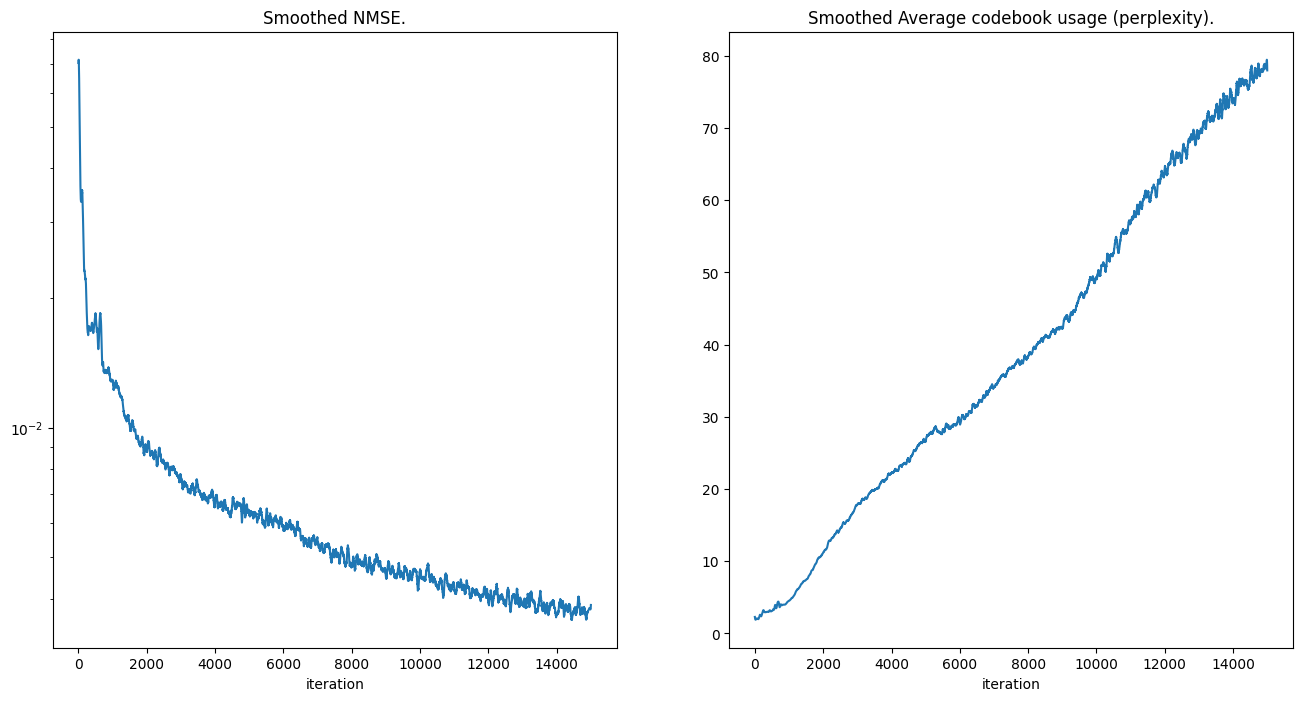

In [ ]:
from scipy.signal import savgol_filter
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

## View reconstructions

In [ ]:
model.eval()

test_batch = next(iter(test_loader))
test_originals = test_batch.to(device)

vq_output_eval = model.pre_vq_conv(model.encoder(test_originals))
_, test_quantize, _, _, _ = model.vq_vae(vq_output_eval)
test_reconstructions = model.decoder(test_quantize)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [72]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

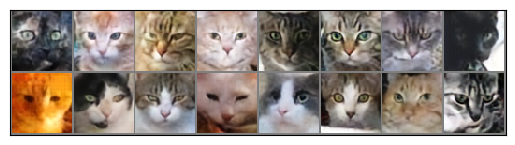

In [ ]:
from torchvision.utils import make_grid
show(make_grid(test_reconstructions.cpu().data)+0.5, )

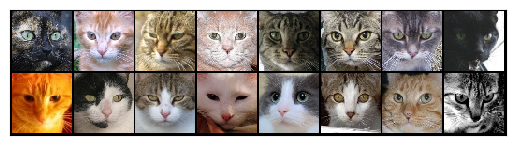

In [ ]:
show(make_grid(test_originals.cpu()+0.5))

In [ ]:
# torch.save(model, '/content/drive/MyDrive/Deep Leraning & Computer Vision/CV_lab10/vqvae.pt')

# Prepare dataset for PixelCNN

In [47]:
model = torch.load('/content/drive/MyDrive/Deep Leraning & Computer Vision/CV_lab10/vqvae.pt')

In [48]:
latent_blocks = []

for batch in tqdm(train_loader):
  batch = batch.to(device)

  batch_encoded = model.encoder(batch)
  batch_encoded_conv = model.pre_vq_conv(batch_encoded)
  _, _, _, _, min_encoding_indices = model.vq_vae(batch_encoded_conv)
  latent_blocks.append(min_encoding_indices)

  0%|          | 0/938 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 938/938 [00:07<00:00, 121.24it/s]


In [54]:
for i in range(len(latent_blocks)):
  latent_blocks[i] = latent_blocks[i].view(-1, 16, 16)

In [55]:
latent_blocks_stacked = torch.cat(latent_blocks)

In [56]:
latent_blocks_stacked = latent_blocks_stacked.cpu()

In [57]:
latent_blocks_stacked.shape

torch.Size([15000, 16, 16])

# PixelCNN

github: https://github.com/MishaLaskin/vqvae/blob/master/pixelcnn/models.py

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions import kl_divergence

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            nn.init.xavier_uniform_(m.weight.data)
            m.bias.data.fill_(0)
        except AttributeError:
            print("Skipping initialization of ", classname)



class GatedActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x, y = x.chunk(2, dim=1)
        return F.tanh(x) * F.sigmoid(y)


class GatedMaskedConv2d(nn.Module):
    def __init__(self, mask_type, dim, kernel, residual=True, n_classes=10):
        super().__init__()
        assert kernel % 2 == 1, print("Kernel size must be odd")
        self.mask_type = mask_type
        self.residual = residual

        self.class_cond_embedding = nn.Embedding(
            n_classes, 2 * dim
        )

        kernel_shp = (kernel // 2 + 1, kernel)  # (ceil(n/2), n)
        padding_shp = (kernel // 2, kernel // 2)
        self.vert_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.vert_to_horiz = nn.Conv2d(2 * dim, 2 * dim, 1)

        kernel_shp = (1, kernel // 2 + 1)
        padding_shp = (0, kernel // 2)
        self.horiz_stack = nn.Conv2d(
            dim, dim * 2,
            kernel_shp, 1, padding_shp
        )

        self.horiz_resid = nn.Conv2d(dim, dim, 1)

        self.gate = GatedActivation()

    def make_causal(self):
        self.vert_stack.weight.data[:, :, -1].zero_()  # Mask final row
        self.horiz_stack.weight.data[:, :, :, -1].zero_()  # Mask final column

    def forward(self, x_v, x_h, h):
        if self.mask_type == 'A':
            self.make_causal()

        h = self.class_cond_embedding(h)
        h_vert = self.vert_stack(x_v)
        h_vert = h_vert[:, :, :x_v.size(-1), :]
        out_v = self.gate(h_vert + h[:, :, None, None])

        h_horiz = self.horiz_stack(x_h)
        h_horiz = h_horiz[:, :, :, :x_h.size(-2)]
        v2h = self.vert_to_horiz(h_vert)

        out = self.gate(v2h + h_horiz + h[:, :, None, None])
        if self.residual:
            out_h = self.horiz_resid(out) + x_h
        else:
            out_h = self.horiz_resid(out)

        return out_v, out_h


class GatedPixelCNN(nn.Module):
    def __init__(self, input_dim=256, dim=64, n_layers=15, n_classes=1):
        super().__init__()
        self.dim = dim

        # Create embedding layer to embed input
        self.embedding = nn.Embedding(input_dim, dim)

        # Building the PixelCNN layer by layer
        self.layers = nn.ModuleList()

        # Initial block with Mask-A convolution
        # Rest with Mask-B convolutions
        for i in range(n_layers):
            mask_type = 'A' if i == 0 else 'B'
            kernel = 7 if i == 0 else 3
            residual = False if i == 0 else True

            self.layers.append(
                GatedMaskedConv2d(mask_type, dim, kernel, residual, n_classes)
            )

        # Add the output layer
        self.output_conv = nn.Sequential(
            nn.Conv2d(dim, 512, 1),
            nn.ReLU(True),
            nn.Conv2d(512, input_dim, 1)
        )

        self.apply(weights_init)

    def forward(self, x, label):
        shp = x.size() + (-1, )
        x = self.embedding(x.view(-1)).view(shp)  # (B, H, W, C)
        x = x.permute(0, 3, 1, 2)  # (B, C, W, H)

        x_v, x_h = (x, x)
        for i, layer in enumerate(self.layers):
            x_v, x_h = layer(x_v, x_h, label)

        return self.output_conv(x_h)

    def generate(self, label, shape=(16, 16), batch_size=64):
        param = next(self.parameters())
        x = torch.zeros(
            (batch_size, *shape),
            dtype=torch.int64, device=param.device
        )

        for i in range(shape[0]):
            for j in range(shape[1]):
                logits = self.forward(x, label)
                probs = F.softmax(logits[:, :, i, j], -1)
                x.data[:, i, j].copy_(
                    probs.multinomial(1).squeeze().data
                )
        return x

In [59]:
class LatentBlockDataset(Dataset):
  def __init__(self, data: torch.Tensor):
    super().__init__()
    self.data = data

  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, index):
    label = 0
    return self.data[index], label

In [60]:
import torchvision.transforms as T
# transform_latent = T.Compose([
#     T.ToTensor()
# ])
df_latent = LatentBlockDataset(latent_blocks_stacked)

In [61]:
loader_latent = DataLoader(df_latent, batch_size=16, shuffle=True, num_workers=2)

In [65]:
model_pixelcnn = GatedPixelCNN(num_embeddings, 16**2, 10, 1).to(device)
criterion = nn.CrossEntropyLoss().cuda()
opt = torch.optim.Adam(model_pixelcnn.parameters(), lr=3e-4)

Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d
Skipping initialization of  GatedMaskedConv2d


In [66]:
def train():
    train_loss = []
    for batch_idx, (x, label) in tqdm(enumerate(loader_latent)):

        # Train PixelCNN with images
        x = x.to(device)
        label = label.to(device)

        logits = model_pixelcnn(x, label)
        logits = logits.permute(0, 2, 3, 1).contiguous()

        loss = criterion(
            logits.view(-1, num_embeddings),
            x.view(-1)
        )

        opt.zero_grad()
        loss.backward()
        opt.step()

        train_loss.append(loss.item())

        if (batch_idx + 1) % 100 == 0:
            print('\tIter: [{}/{} ({:.0f}%)]\tLoss: {}'.format(
                batch_idx * len(x), 15000,
                100 * batch_idx / len(loader_latent),
                np.asarray(train_loss)[-100:].mean(0)
            ))

In [67]:
train()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
101it [00:17,  5.73it/s]

	Iter: [1584/15000 (11%)]	Loss: 4.003039586544037


201it [00:34,  5.72it/s]

	Iter: [3184/15000 (21%)]	Loss: 3.664953968524933


301it [00:52,  5.81it/s]

	Iter: [4784/15000 (32%)]	Loss: 3.610939919948578


401it [01:09,  5.83it/s]

	Iter: [6384/15000 (43%)]	Loss: 3.5659364342689512


501it [01:26,  5.88it/s]

	Iter: [7984/15000 (53%)]	Loss: 3.526110816001892


601it [01:43,  5.81it/s]

	Iter: [9584/15000 (64%)]	Loss: 3.5055105090141296


701it [02:00,  5.76it/s]

	Iter: [11184/15000 (75%)]	Loss: 3.464546971321106


801it [02:18,  5.78it/s]

	Iter: [12784/15000 (85%)]	Loss: 3.482980556488037


901it [02:35,  5.82it/s]

	Iter: [14384/15000 (96%)]	Loss: 3.436985273361206


938it [02:41,  5.81it/s]


In [68]:
epochs = 10
for i in range(epochs):
  print(f'epoch {i}')
  train()
  print('------------------------------------------------')

epoch 0


101it [00:17,  5.75it/s]

	Iter: [1584/15000 (11%)]	Loss: 3.3720751285552977


201it [00:34,  5.72it/s]

	Iter: [3184/15000 (21%)]	Loss: 3.3401695561408995


301it [00:52,  5.82it/s]

	Iter: [4784/15000 (32%)]	Loss: 3.3130141997337343


401it [01:09,  5.78it/s]

	Iter: [6384/15000 (43%)]	Loss: 3.2913112831115723


501it [01:26,  5.86it/s]

	Iter: [7984/15000 (53%)]	Loss: 3.274152934551239


601it [01:43,  5.83it/s]

	Iter: [9584/15000 (64%)]	Loss: 3.2442145943641663


701it [02:00,  5.81it/s]

	Iter: [11184/15000 (75%)]	Loss: 3.2447702789306643


801it [02:18,  5.82it/s]

	Iter: [12784/15000 (85%)]	Loss: 3.2517307686805723


901it [02:35,  5.82it/s]

	Iter: [14384/15000 (96%)]	Loss: 3.2199869036674498


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 1



101it [00:17,  5.82it/s]

	Iter: [1584/15000 (11%)]	Loss: 3.0979856944084165


201it [00:34,  5.85it/s]

	Iter: [3184/15000 (21%)]	Loss: 3.1186310601234437


301it [00:51,  5.75it/s]

	Iter: [4784/15000 (32%)]	Loss: 3.10522497177124


401it [01:08,  5.73it/s]

	Iter: [6384/15000 (43%)]	Loss: 3.0736561846733093


501it [01:26,  5.74it/s]

	Iter: [7984/15000 (53%)]	Loss: 3.1163431668281554


601it [01:43,  5.82it/s]

	Iter: [9584/15000 (64%)]	Loss: 3.085569529533386


701it [02:00,  5.77it/s]

	Iter: [11184/15000 (75%)]	Loss: 3.0882670426368715


801it [02:18,  5.84it/s]

	Iter: [12784/15000 (85%)]	Loss: 3.0723043131828307


901it [02:35,  5.82it/s]

	Iter: [14384/15000 (96%)]	Loss: 3.0802630758285523


938it [02:41,  5.81it/s]

------------------------------------------------
epoch 2



101it [00:17,  5.81it/s]

	Iter: [1584/15000 (11%)]	Loss: 2.9120663452148436


201it [00:34,  5.83it/s]

	Iter: [3184/15000 (21%)]	Loss: 2.938579332828522


301it [00:51,  5.81it/s]

	Iter: [4784/15000 (32%)]	Loss: 2.935966603755951


401it [01:09,  5.81it/s]

	Iter: [6384/15000 (43%)]	Loss: 2.9328535747528077


501it [01:26,  5.80it/s]

	Iter: [7984/15000 (53%)]	Loss: 2.9396676301956175


601it [01:43,  5.78it/s]

	Iter: [9584/15000 (64%)]	Loss: 2.9370417261123656


701it [02:00,  5.84it/s]

	Iter: [11184/15000 (75%)]	Loss: 2.924913234710693


801it [02:18,  5.81it/s]

	Iter: [12784/15000 (85%)]	Loss: 2.9233433175086976


901it [02:35,  5.77it/s]

	Iter: [14384/15000 (96%)]	Loss: 2.905100848674774


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 3



101it [00:17,  5.73it/s]

	Iter: [1584/15000 (11%)]	Loss: 2.724540946483612


201it [00:34,  5.78it/s]

	Iter: [3184/15000 (21%)]	Loss: 2.763369460105896


301it [00:51,  5.81it/s]

	Iter: [4784/15000 (32%)]	Loss: 2.7685628366470336


401it [01:09,  5.83it/s]

	Iter: [6384/15000 (43%)]	Loss: 2.776634838581085


501it [01:26,  5.78it/s]

	Iter: [7984/15000 (53%)]	Loss: 2.781158640384674


601it [01:43,  5.82it/s]

	Iter: [9584/15000 (64%)]	Loss: 2.749665756225586


701it [02:00,  5.81it/s]

	Iter: [11184/15000 (75%)]	Loss: 2.7549477863311767


801it [02:18,  5.76it/s]

	Iter: [12784/15000 (85%)]	Loss: 2.7408174109458923


901it [02:35,  5.82it/s]

	Iter: [14384/15000 (96%)]	Loss: 2.7706670427322386


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 4



101it [00:17,  5.79it/s]

	Iter: [1584/15000 (11%)]	Loss: 2.529612901210785


201it [00:34,  5.79it/s]

	Iter: [3184/15000 (21%)]	Loss: 2.57487931728363


301it [00:51,  5.77it/s]

	Iter: [4784/15000 (32%)]	Loss: 2.5833875870704652


401it [01:09,  5.82it/s]

	Iter: [6384/15000 (43%)]	Loss: 2.6158427166938782


501it [01:26,  5.84it/s]

	Iter: [7984/15000 (53%)]	Loss: 2.592324695587158


601it [01:43,  5.78it/s]

	Iter: [9584/15000 (64%)]	Loss: 2.603206295967102


701it [02:00,  5.83it/s]

	Iter: [11184/15000 (75%)]	Loss: 2.5968893933296204


801it [02:18,  5.80it/s]

	Iter: [12784/15000 (85%)]	Loss: 2.56852557182312


901it [02:35,  5.81it/s]

	Iter: [14384/15000 (96%)]	Loss: 2.5752520537376404


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 5



101it [00:17,  5.76it/s]

	Iter: [1584/15000 (11%)]	Loss: 2.331304807662964


201it [00:34,  5.79it/s]

	Iter: [3184/15000 (21%)]	Loss: 2.3823415279388427


301it [00:51,  5.82it/s]

	Iter: [4784/15000 (32%)]	Loss: 2.3830343747138976


401it [01:09,  5.80it/s]

	Iter: [6384/15000 (43%)]	Loss: 2.421144404411316


501it [01:26,  5.81it/s]

	Iter: [7984/15000 (53%)]	Loss: 2.398177075386047


601it [01:43,  5.81it/s]

	Iter: [9584/15000 (64%)]	Loss: 2.4336280632019043


701it [02:00,  5.87it/s]

	Iter: [11184/15000 (75%)]	Loss: 2.444219374656677


801it [02:18,  5.81it/s]

	Iter: [12784/15000 (85%)]	Loss: 2.4057617139816285


901it [02:35,  5.79it/s]

	Iter: [14384/15000 (96%)]	Loss: 2.4348347973823548


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 6



101it [00:17,  5.73it/s]

	Iter: [1584/15000 (11%)]	Loss: 2.1448300755023957


201it [00:34,  5.82it/s]

	Iter: [3184/15000 (21%)]	Loss: 2.2028951346874237


301it [00:51,  5.80it/s]

	Iter: [4784/15000 (32%)]	Loss: 2.2235495710372923


401it [01:09,  5.75it/s]

	Iter: [6384/15000 (43%)]	Loss: 2.249868446588516


501it [01:26,  5.80it/s]

	Iter: [7984/15000 (53%)]	Loss: 2.258576339483261


601it [01:43,  5.79it/s]

	Iter: [9584/15000 (64%)]	Loss: 2.272465500831604


701it [02:00,  5.83it/s]

	Iter: [11184/15000 (75%)]	Loss: 2.2282369542121887


801it [02:18,  5.79it/s]

	Iter: [12784/15000 (85%)]	Loss: 2.2296882379055023


901it [02:35,  5.83it/s]

	Iter: [14384/15000 (96%)]	Loss: 2.228012582063675


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 7



101it [00:17,  5.81it/s]

	Iter: [1584/15000 (11%)]	Loss: 1.9790982043743133


201it [00:34,  5.82it/s]

	Iter: [3184/15000 (21%)]	Loss: 2.01118435382843


301it [00:51,  5.77it/s]

	Iter: [4784/15000 (32%)]	Loss: 2.0442354595661163


401it [01:09,  5.83it/s]

	Iter: [6384/15000 (43%)]	Loss: 2.058067833185196


501it [01:26,  5.81it/s]

	Iter: [7984/15000 (53%)]	Loss: 2.0724843335151673


601it [01:43,  5.79it/s]

	Iter: [9584/15000 (64%)]	Loss: 2.071207710504532


701it [02:00,  5.80it/s]

	Iter: [11184/15000 (75%)]	Loss: 2.0729004645347597


801it [02:18,  5.83it/s]

	Iter: [12784/15000 (85%)]	Loss: 2.0977445101737975


901it [02:35,  5.79it/s]

	Iter: [14384/15000 (96%)]	Loss: 2.0828910422325135


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 8



101it [00:17,  5.79it/s]

	Iter: [1584/15000 (11%)]	Loss: 1.809216732978821


201it [00:34,  5.72it/s]

	Iter: [3184/15000 (21%)]	Loss: 1.8579825699329375


301it [00:51,  5.75it/s]

	Iter: [4784/15000 (32%)]	Loss: 1.8670245230197906


401it [01:09,  5.81it/s]

	Iter: [6384/15000 (43%)]	Loss: 1.8900568985939026


501it [01:26,  5.78it/s]

	Iter: [7984/15000 (53%)]	Loss: 1.908412845134735


601it [01:43,  5.81it/s]

	Iter: [9584/15000 (64%)]	Loss: 1.9142537689208985


701it [02:00,  5.79it/s]

	Iter: [11184/15000 (75%)]	Loss: 1.9360954308509826


801it [02:18,  5.79it/s]

	Iter: [12784/15000 (85%)]	Loss: 1.943412584066391


901it [02:35,  5.82it/s]

	Iter: [14384/15000 (96%)]	Loss: 1.9241524589061738


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 9



101it [00:17,  5.79it/s]

	Iter: [1584/15000 (11%)]	Loss: 1.6203281772136688


201it [00:34,  5.79it/s]

	Iter: [3184/15000 (21%)]	Loss: 1.7008654940128327


301it [00:51,  5.80it/s]

	Iter: [4784/15000 (32%)]	Loss: 1.7418310129642487


401it [01:09,  5.74it/s]

	Iter: [6384/15000 (43%)]	Loss: 1.7529522156715394


501it [01:26,  5.81it/s]

	Iter: [7984/15000 (53%)]	Loss: 1.7768585681915283


601it [01:43,  5.83it/s]

	Iter: [9584/15000 (64%)]	Loss: 1.761918089389801


701it [02:00,  5.77it/s]

	Iter: [11184/15000 (75%)]	Loss: 1.7940381717681886


801it [02:18,  5.81it/s]

	Iter: [12784/15000 (85%)]	Loss: 1.8087360548973084


901it [02:35,  5.81it/s]

	Iter: [14384/15000 (96%)]	Loss: 1.7808559656143188


938it [02:41,  5.80it/s]

------------------------------------------------


In [74]:
opt = torch.optim.Adam(model_pixelcnn.parameters(), lr=1e-4)
epochs = 10
for i in range(epochs):
  print(f'epoch {i}')
  train()
  print('------------------------------------------------')

epoch 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
101it [00:17,  5.69it/s]

	Iter: [1584/15000 (11%)]	Loss: 1.4183060216903687


201it [00:35,  5.75it/s]

	Iter: [3184/15000 (21%)]	Loss: 1.3425032079219819


301it [00:52,  5.82it/s]

	Iter: [4784/15000 (32%)]	Loss: 1.3430133670568467


401it [01:09,  5.88it/s]

	Iter: [6384/15000 (43%)]	Loss: 1.3022946286201478


501it [01:26,  5.82it/s]

	Iter: [7984/15000 (53%)]	Loss: 1.297798924446106


601it [01:43,  5.79it/s]

	Iter: [9584/15000 (64%)]	Loss: 1.3201494532823563


701it [02:01,  5.81it/s]

	Iter: [11184/15000 (75%)]	Loss: 1.2833188444375991


801it [02:18,  5.79it/s]

	Iter: [12784/15000 (85%)]	Loss: 1.276300698518753


901it [02:35,  5.80it/s]

	Iter: [14384/15000 (96%)]	Loss: 1.309446760416031


937it [02:41,  5.79it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
938it [02:42,  5.78it/s]

------------------------------------------------
epoch 1



101it [00:17,  5.77it/s]

	Iter: [1584/15000 (11%)]	Loss: 1.084670785665512


201it [00:34,  5.81it/s]

	Iter: [3184/15000 (21%)]	Loss: 1.0989919984340668


301it [00:51,  5.80it/s]

	Iter: [4784/15000 (32%)]	Loss: 1.1157519894838333


401it [01:09,  5.81it/s]

	Iter: [6384/15000 (43%)]	Loss: 1.1114163511991502


501it [01:26,  5.79it/s]

	Iter: [7984/15000 (53%)]	Loss: 1.1236316907405852


601it [01:43,  5.83it/s]

	Iter: [9584/15000 (64%)]	Loss: 1.1247551101446152


701it [02:00,  5.85it/s]

	Iter: [11184/15000 (75%)]	Loss: 1.167687898874283


801it [02:18,  5.81it/s]

	Iter: [12784/15000 (85%)]	Loss: 1.1656904929876328


901it [02:35,  5.81it/s]

	Iter: [14384/15000 (96%)]	Loss: 1.1453435873985292


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 2



101it [00:17,  5.84it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.9702846676111221


201it [00:34,  5.83it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.9844089448451996


301it [00:51,  5.73it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.9998591840267181


401it [01:09,  5.81it/s]

	Iter: [6384/15000 (43%)]	Loss: 1.0116083800792695


501it [01:26,  5.80it/s]

	Iter: [7984/15000 (53%)]	Loss: 1.0317784500122071


601it [01:43,  5.72it/s]

	Iter: [9584/15000 (64%)]	Loss: 1.0257272517681122


701it [02:00,  5.78it/s]

	Iter: [11184/15000 (75%)]	Loss: 1.0247699207067489


801it [02:18,  5.85it/s]

	Iter: [12784/15000 (85%)]	Loss: 1.0630498725175856


901it [02:35,  5.78it/s]

	Iter: [14384/15000 (96%)]	Loss: 1.0557666993141175


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 3



101it [00:17,  5.82it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.8633808499574661


201it [00:34,  5.73it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.880957852602005


301it [00:51,  5.82it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.9184643852710724


401it [01:09,  5.85it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.9238351213932038


501it [01:26,  5.81it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.9429907518625259


601it [01:43,  5.81it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.9333572578430176


701it [02:00,  5.83it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.968083004951477


801it [02:17,  5.75it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.964575132727623


901it [02:35,  5.79it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.9586670273542404


938it [02:41,  5.81it/s]

------------------------------------------------
epoch 4



101it [00:17,  5.81it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.790776486992836


201it [00:34,  5.79it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.8189323502779007


301it [00:51,  5.79it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.8268039572238922


401it [01:09,  5.71it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.839102024435997


501it [01:26,  5.84it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.871820085644722


601it [01:43,  5.81it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.8734670060873032


701it [02:00,  5.76it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.8890695124864578


801it [02:18,  5.81it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.8814448738098144


901it [02:35,  5.78it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.8863908290863037


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 5



101it [00:17,  5.81it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.7337741327285766


201it [00:34,  5.81it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.7309337466955185


301it [00:51,  5.76it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.7529945915937424


401it [01:09,  5.83it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.7687542170286179


501it [01:26,  5.84it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.802664452791214


601it [01:43,  5.73it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.8093465238809585


701it [02:00,  5.84it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.8058812725543976


801it [02:18,  5.85it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.8123764026165009


901it [02:35,  5.74it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.8348746228218079


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 6



101it [00:17,  5.80it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.6893229132890701


201it [00:34,  5.74it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.6960999047756196


301it [00:51,  5.82it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.6970981431007385


401it [01:09,  5.84it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.6980467009544372


501it [01:26,  5.80it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.7210306209325791


601it [01:43,  5.85it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.7444922000169754


701it [02:00,  5.82it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.7410921037197113


801it [02:18,  5.76it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.7587821686267853


901it [02:35,  5.81it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.7800443834066391


938it [02:41,  5.81it/s]

------------------------------------------------
epoch 7



101it [00:17,  5.77it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.6172988405823707


201it [00:34,  5.80it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.6360756897926331


301it [00:51,  5.78it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.662552787065506


401it [01:09,  5.77it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.6753379863500595


501it [01:26,  5.80it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.6852819910645485


601it [01:43,  5.81it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.6717956030368805


701it [02:00,  5.78it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.7088022565841675


801it [02:18,  5.78it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.7231466287374496


901it [02:35,  5.81it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.7097609311342239


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 8



101it [00:17,  5.82it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.5904962840676308


201it [00:34,  5.80it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.5983005422353744


301it [00:51,  5.80it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.601799219250679


401it [01:09,  5.79it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.6217540585994721


501it [01:26,  5.84it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.6409685462713242


601it [01:43,  5.77it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.6422588065266609


701it [02:00,  5.81it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.6502255699038506


801it [02:17,  5.82it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.672327710390091


901it [02:35,  5.75it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.6753441891074181


938it [02:41,  5.81it/s]

------------------------------------------------
epoch 9



101it [00:17,  5.75it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.5595904982089996


201it [00:34,  5.81it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.5620470732450485


301it [00:51,  5.81it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.5750240007042885


401it [01:09,  5.78it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.5923078048229218


501it [01:26,  5.77it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.6014592692255973


601it [01:43,  5.84it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.6113919350504875


701it [02:00,  5.81it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.6080712682008743


801it [02:18,  5.72it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.6421727898716927


901it [02:35,  5.81it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.6253314533829689


938it [02:41,  5.80it/s]

------------------------------------------------


In [83]:
opt = torch.optim.Adam(model_pixelcnn.parameters(), lr=5e-5)
epochs = 10
for i in range(epochs):
  print(f'epoch {i}')
  train()
  print('------------------------------------------------')

epoch 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
101it [00:16,  6.00it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.5134798091650009


201it [00:33,  5.95it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.49524580121040346


301it [00:50,  5.86it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.4881633475422859


401it [01:07,  5.74it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.4859788769483566


501it [01:24,  5.78it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.49571340918540957


601it [01:41,  5.85it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.48834996312856677


701it [01:59,  5.76it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.4897566020488739


801it [02:16,  5.81it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.4727316579222679


901it [02:33,  5.84it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.47491287589073183


937it [02:39,  5.84it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
938it [02:39,  5.87it/s]

------------------------------------------------
epoch 1



101it [00:17,  5.84it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.4127938795089722


201it [00:34,  5.82it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.4060087674856186


301it [00:51,  5.73it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.41763139426708223


401it [01:09,  5.80it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.41478787541389467


501it [01:26,  5.82it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.4228051960468292


601it [01:43,  5.84it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.4356696751713753


701it [02:00,  5.83it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.42843868762254717


801it [02:18,  5.81it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.4441144400835037


901it [02:35,  5.82it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.43752835094928744


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 2



101it [00:17,  5.80it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.3837795978784561


201it [00:34,  5.78it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.3872023797035217


301it [00:51,  5.79it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.3921210917830467


401it [01:09,  5.78it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.39219082981348036


501it [01:26,  5.77it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.3979243797063827


601it [01:43,  5.78it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.41169300317764285


701it [02:00,  5.80it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.4046530455350876


801it [02:18,  5.81it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.41410151481628416


901it [02:35,  5.80it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.42379138827323914


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 3



101it [00:17,  5.74it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.36620635628700254


201it [00:34,  5.80it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.35963453352451324


301it [00:51,  5.79it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.36943518489599225


401it [01:09,  5.80it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.385132797062397


501it [01:26,  5.83it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.38864277094602584


601it [01:43,  5.85it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.3944761070609093


701it [02:00,  5.81it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.39751719176769257


801it [02:17,  5.75it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.3938603848218918


901it [02:35,  5.82it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.39867930561304094


938it [02:41,  5.81it/s]

------------------------------------------------
epoch 4



101it [00:17,  5.81it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.3547891283035278


201it [00:34,  5.80it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.353351431787014


301it [00:51,  5.80it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.3642444136738777


401it [01:09,  5.81it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.36393469721078875


501it [01:26,  5.80it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.36165953040122983


601it [01:43,  5.77it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.37302092105150225


701it [02:00,  5.73it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.37322220295667646


801it [02:18,  5.84it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.37954363107681277


901it [02:35,  5.83it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.3772405353188515


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 5



101it [00:17,  5.79it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.34212713450193405


201it [00:34,  5.79it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.33834334135055544


301it [00:51,  5.82it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.3487012782692909


401it [01:09,  5.79it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.34551353424787523


501it [01:26,  5.79it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.3563207459449768


601it [01:43,  5.78it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.3531595665216446


701it [02:00,  5.83it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.34613648176193235


801it [02:18,  5.81it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.36025814950466156


901it [02:35,  5.80it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.3589102652668953


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 6



101it [00:17,  5.76it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.325211678147316


201it [00:34,  5.82it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.3244480001926422


301it [00:51,  5.83it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.3261647135019302


401it [01:09,  5.74it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.33463963627815246


501it [01:26,  5.80it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.3419956377148628


601it [01:43,  5.80it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.33964823961257934


701it [02:00,  5.76it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.3413916173577309


801it [02:17,  5.83it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.3491045224666596


901it [02:35,  5.80it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.3498103478550911


938it [02:41,  5.81it/s]

------------------------------------------------
epoch 7



101it [00:17,  5.83it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.3098709757626057


201it [00:34,  5.80it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.3140118183195591


301it [00:51,  5.76it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.31414111897349356


401it [01:09,  5.82it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.3236104586720467


501it [01:26,  5.80it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.32124774158000946


601it [01:43,  5.77it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.3232590666413307


701it [02:00,  5.80it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.33709757298231124


801it [02:18,  5.74it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.3346689009666443


901it [02:35,  5.75it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.34139532417058943


938it [02:41,  5.80it/s]

------------------------------------------------
epoch 8



101it [00:17,  5.78it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.2944137863814831


201it [00:34,  5.81it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.29703568816185


301it [00:51,  5.85it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.31138933792710305


401it [01:09,  5.83it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.31238835483789446


501it [01:26,  5.78it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.31894882798194885


601it [01:43,  5.83it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.31845293164253236


701it [02:00,  5.82it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.32466161251068115


801it [02:18,  5.80it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.31597645610570907


901it [02:35,  5.83it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.3279238758981228


938it [02:41,  5.81it/s]

------------------------------------------------
epoch 9



101it [00:17,  5.80it/s]

	Iter: [1584/15000 (11%)]	Loss: 0.2914200213551521


201it [00:34,  5.80it/s]

	Iter: [3184/15000 (21%)]	Loss: 0.29294239476323125


301it [00:51,  5.78it/s]

	Iter: [4784/15000 (32%)]	Loss: 0.29347737118601797


401it [01:09,  5.80it/s]

	Iter: [6384/15000 (43%)]	Loss: 0.30094165697693825


501it [01:26,  5.79it/s]

	Iter: [7984/15000 (53%)]	Loss: 0.3015137733519077


601it [01:43,  5.83it/s]

	Iter: [9584/15000 (64%)]	Loss: 0.30929853036999705


701it [02:00,  5.87it/s]

	Iter: [11184/15000 (75%)]	Loss: 0.31459606140851976


801it [02:18,  5.83it/s]

	Iter: [12784/15000 (85%)]	Loss: 0.31911122784018514


901it [02:35,  5.78it/s]

	Iter: [14384/15000 (96%)]	Loss: 0.3147407880425453


938it [02:41,  5.80it/s]

------------------------------------------------


In [84]:
torch.save(model_pixelcnn, '/content/drive/MyDrive/Deep Leraning & Computer Vision/CV_lab10/pixelcnn.pt')

In [76]:
from torchvision.utils import make_grid
def generate_samples():
    label = torch.arange(1).expand(4, 4).contiguous().view(-1)
    label = label.long().to(device)

    x_tilde = model_pixelcnn.generate(label, shape=(16, 16), batch_size=16)
    output = model.vq_vae.embedding(x_tilde).permute(0, 3, 1, 2)
    output = model.decoder(output)

    show(make_grid(output.cpu().data)+0.5, )
    return output

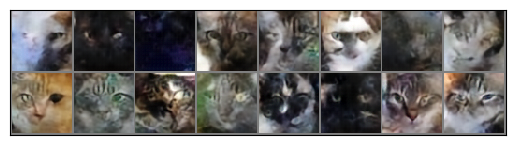

In [73]:
#10 epochs
output = generate_samples()

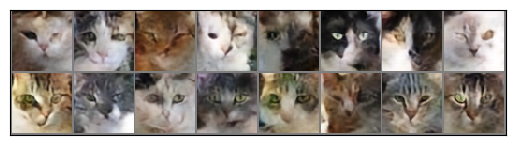

In [77]:
#20 epochs
output2 = generate_samples()

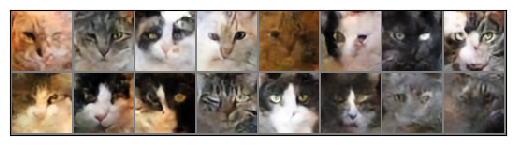

In [86]:
#30 epochs
output3 = generate_samples()

In [80]:
count = 0
print('VQ-VAE:')
for param in model.parameters():
  print(param.numel())
  count += param.numel()

count2 = 0
print('---------------')
for param in model_pixelcnn.parameters():
  print(param.numel())
  count2 += param.numel()

VQ-VAE:
6144
128
524288
256
589824
256
73728
8192
16384
64
32768
147456
256
73728
8192
524288
128
6144
3
---------------
131072
512
3670016
512
262144
512
524288
512
65536
256
512
786432
512
262144
512
262144
512
65536
256
512
786432
512
262144
512
262144
512
65536
256
512
786432
512
262144
512
262144
512
65536
256
512
786432
512
262144
512
262144
512
65536
256
512
786432
512
262144
512
262144
512
65536
256
512
786432
512
262144
512
262144
512
65536
256
512
786432
512
262144
512
262144
512
65536
256
512
786432
512
262144
512
262144
512
65536
256
512
786432
512
262144
512
262144
512
65536
256
131072
512
262144
512


In [82]:
print(f'VQ-VAE: {count} parameters')
print(f'PixelCNN: {count2} parameters')

VQ-VAE: 2012227 parameters
PixelCNN: 17456640 parameters
